# Clustering 1

We will look at the K-Means clustering algorithm.

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Let us create a nice dataset.

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=400, centers=5, random_state=1)

# The first three points
print(X[:3])
print(y[:3])

[[ -5.42151359  -3.22849719]
 [-10.49592607  -4.26433353]
 [ -6.10492652  -4.25279343]]
[3 1 3]


The __X__ matrix contain two features for each point. The points were generated from 5 clusters, given by **y**, but we won't tell the clustering algorithm that. We will let it figure out the clusters for itself.

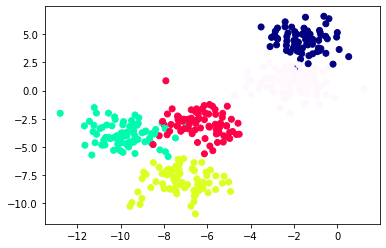

In [3]:
scatter(X[:,0], X[:,1], c=y, cmap='gist_ncar')
savefig('Clustering_1_data/five.png')

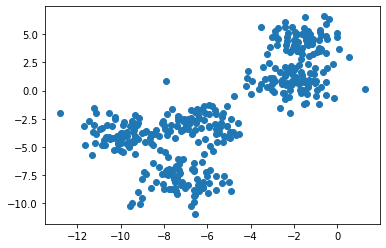

In [4]:
scatter(X[:,0], X[:,1])

Let us run K-Means and find the centroids.

In [5]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, random_state=1)

In [6]:
model.fit(X)

KMeans(n_clusters=5, random_state=1)

In [7]:
# Get the cluster centers
print(model.cluster_centers_)

[[-1.59006219  4.50187467]
 [-9.9182243  -3.91849066]
 [-7.17962063 -7.96038304]
 [-6.29549173 -2.90329602]
 [-2.02887691  0.71544035]]


In [8]:
# Get the cluster "labels" for, say, the first 5 points
model.labels_[:5]

array([3, 1, 3, 2, 3], dtype=int32)

Let us plot the cluster centers.

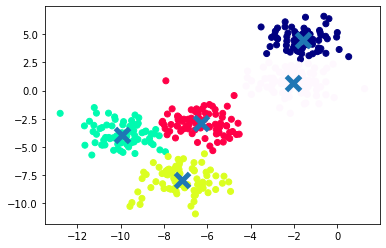

In [9]:
scatter(X[:,0], X[:,1], c=model.labels_, cmap='gist_ncar')
scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker="x", s=200, linewidths=5)
savefig('Clustering_1_data/clusters.png')

#### What happens if we use too many clusters?

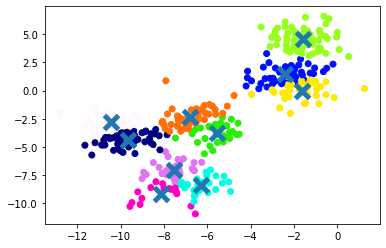

In [10]:
kmeans = KMeans(n_clusters=10, random_state=1)
kmeans.fit(X)
scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='gist_ncar')
scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", s=200, linewidths=5)
savefig('Clustering_1_data/too_many_clusters.png')

We end up with multiple centers for each cluster.

#### Too few clusters?

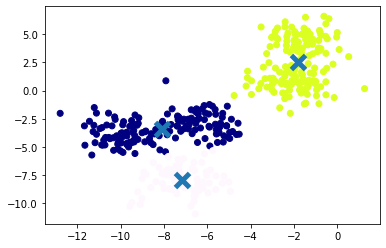

In [11]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X)
scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='gist_ncar')
scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", s=200, linewidths=5)
savefig('Clustering_1_data/too_few_clusters.png')

As expected, it merges some clusters.

#### Picking the right number of clusters

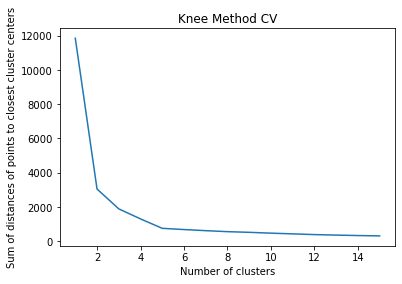

In [13]:
sum_of_distances = {}
for num_clusters in range(1,16):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(X)
    sum_of_distances[num_clusters] = kmeans.inertia_
Series(sum_of_distances).sort_index().plot()
xlabel('Number of clusters')
ylabel('Sum of distances of points to closest cluster centers')
title("Knee Method CV")
savefig('Clustering_1_data/inertia.png')

* As the number of cluster centers increase
    * each point has more opportunities to be close to some center,
    * so distance to the closest center decreases
    * as does the sum of distances of all points to their closest centers

* However, once we have the _right_ number of centers
    * the reduction in sum of distances is very small

* The point where the plot seems to flatten out gives the right number of clusters
    * Here, around 5 clusters

Let us do clustering on another interesting dataset: [handwritten digits](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html). We will follow the example [here](http://nbviewer.ipython.org/github/gmonce/scikit-learn-book/blob/master/Chapter%203%20-%20Unsupervised%20Learning%20-%20Clustering%20Handwritten%20Digits.ipynb).

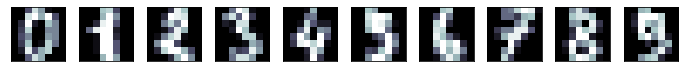

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(12,1))
for i in range(10):
    axes[i].imshow(digits.images[i], cmap=cm.bone)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

What do the images look like?

In [15]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

It is a 2-D matrix of pixel values, with 0 being the _black_ pixels, and bigger numbers representing _whiter_ pixels. We also have the same information available as an array (think: list).

In [16]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Before processing, we will first scale the data. To understand the need for scaling, consider the pixel on the top left.

* It is almost always black.
* So, if in some image, it is white, that should be considered a more important event than some other random pixel being white.

Scaling deals with such issues.

In [17]:
from sklearn.preprocessing import scale
scaled_images = scale(digits.data)

In [18]:
scaled_images[0]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

Each feature gets scaled such that its mean is 0, and its _variance_ is 1.0.

The data is in ordered form: digits 0 to 9 follow consecutively. This can sometimes throw off the algorithm, so as a preprocessing step before running K-Means, we will shuffle the data.

In [19]:
from sklearn.utils import shuffle

# Create a permutation of the number of datapoints
permutation = shuffle(range(len(digits.data)))

data_shuffled = scaled_images[permutation]
images_shuffled = digits.images[permutation]
target_shuffle = digits.target[permutation]

Now, we run K-Means.

In [20]:
# Run K-Means with the 'k-means++' initialization. You can play around with others.
kmeans = KMeans(init='k-means++', n_clusters=10, random_state=1)
kmeans.fit(data_shuffled)

KMeans(n_clusters=10, random_state=1)

Finally, let us plot the clusters.

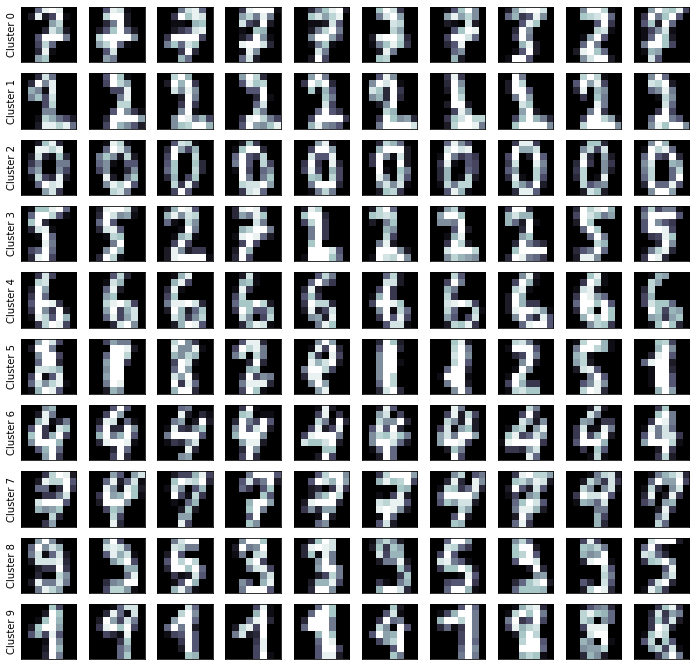

In [21]:
fig, axes = subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(12,12))
for cluster in range(10):
    # For each kmeans cluster, select the datapoints corresponding to that cluster
    mask = (kmeans.labels_ == cluster)
    cluster_images = images_shuffled[mask]
    
    # Plot the first 10 images from each cluster
    for i in range(10):
        axes[cluster][i].imshow(cluster_images[i], cmap=cm.bone)
        axes[cluster][i].set_xticks([])
        axes[cluster][i].set_yticks([])
        
    axes[cluster][0].set_ylabel('Cluster ' + str(cluster))